# **Part 2: Class-Conditional GANs for Image Generation** (20 points)

### **Learning Objectives**
- Implement and train a class-conditional GAN on `MNIST`
- Quantitatively evaluate model performance using `Fréchet Inception Distance (FID)`

### **Implementation Tasks**
1. **Model Training**:
   - Train a class-conditional GANs that generates MNIST digits
        - Vanilla GAN Loss
        - Non-Saturating Loss with $R_1$ regularization
        - Non-Saturating Loss with $R_1$ regularization and unconditional discriminator

2. **Performance Evaluation**:
   - Compute FID scores between generated and real MNIST samples
   - Compare results across different training configurations

### **Resources**

- **GAN's Tutorial:** [From GAN to WGAN](https://lilianweng.github.io/posts/2017-08-20-gan/)

- **Implementation Examples:** [PyTorch-GAN Repo](https://github.com/eriklindernoren/PyTorch-GAN/tree/master)

In [1]:
!pip install torchmetrics[image] -q

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
from torch.utils.data import DataLoader
from torchmetrics.image.fid import FrechetInceptionDistance
import torchvision.transforms.functional as TF
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm import tqdm

In [3]:
DEVICE = torch.device(f"cuda:{torch.cuda.current_device()}" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

## 1. Dataset Preparation (1 point)

Use the MNIST dataset from `torchvision.datasets`. Note that the sampled batches $B_{ds}$ from the dataset must include the class labels of the images.

In [ ]:
# Write necessary transform operations
transform = ... # YOUR CODE HERE

mnist_dataset = ... # YOUR CODE HERE

batch_size = 10
dataloader = ... # YOUR CODE HERE

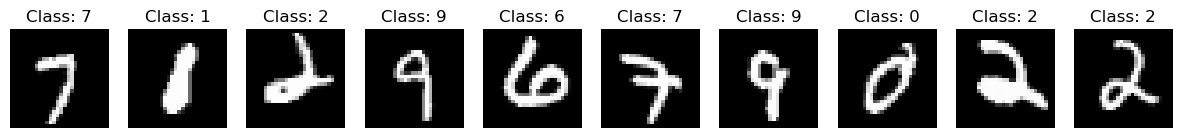

In [ ]:
def show_batch(data_loader: DataLoader):
    ... # YOUR CODE HERE
    plt.show()


show_batch(dataloader)

## 2. Generator and Discriminator architecture (3 points)  

In this task you should implement architecture for generator and discriminator models.

The generator model ${\color{blue}G_\theta}(z, c)$ should take as input:  
- A latent vector $z \sim {\color{purple}p_Z}(\cdot)$  
- A class label $\color{orange}c$ (digit)  

The class-conditional discriminator ${\color{red}D_\omega}(x, c)$ must accept:  
- Real/generated `MNIST` images $x$ 
- The corresponding class label $\color{orange}c$  

**Note:** When working with images, it is common to use **Convolutional Neural Networks (CNNs)**. Such architectures were covered in **Assignment 3.2** during the **1st GAN seminar**.  

There are various approaches to applying conditions—in this task, you must implement the simplest method:  
- Use `nn.Embedding` to obtain embeddings for class vectors (of the required dimension)  
- Feed the generator (or discriminator) the concatenation of either:  
  - Noise + corresponding class embeddings (for the generator)  
  - Images + corresponding class embeddings (for the discriminator)  

In [6]:
def plot_images(batch_x: torch.Tensor, batch_y: torch.Tensor, title: str | None = None):
    fig, axes = plt.subplots(1, 10, figsize=(10, 2))
    if title is not None:
        fig.suptitle(title)
    for i in range(10):
        axes[i].set_title(f"Label: {round(batch_y[i].item())}")
        axes[i].imshow(batch_x[i].squeeze(), cmap="gray")
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    fig.tight_layout(pad=0.1)
    plt.show()


def plot_losses(gen_losses: list[float], disc_losses: list[float]) -> None:
    _, axes = plt.subplots(1, 2, figsize=(10, 3))
    axes[0].plot(gen_losses)
    axes[0].set_title("Generator Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].grid("on")

    axes[1].plot(disc_losses)
    axes[1].set_title("Discriminator Loss")
    axes[1].set_xlabel("Epoch")
    axes[1].grid("on")
    plt.show()

**Select a model architecture.** You may:  
- Use an entirely new class, **or**  
- Adapt the proposed structure.  

For implementation guidance, you may refer to:  
- Seminar materials  
- [PyTorch’s DCGAN Tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)  

In [ ]:
# Generator Architecture
class ConditionalConvGenerator(nn.Module):

    def __init__(self, input_size: int = 128, num_classes: int = 10, device: torch.device = DEVICE) -> None:
        super().__init__()
        self.n_channels = 64
        self.input_size = input_size
        self.num_classes = num_classes

        self.linear_block = nn.Sequential(
            ... # YOUR CODE HERE
        )

        self.conv_block = nn.Sequential(
            nn.ConvTranspose2d(...) # YOUR CODE HERE
            nn.BatchNorm2d(...) # YOUR CODE HERE
            nn.ReLU(...), # YOUR CODE HERE
            ... # YOUR CODE HERE
        )

        self.label_embedding = ... # YOUR CODE HERE
        self.device = device

        self.noise = ... # YOUR CODE HERE

    def forward(self, z: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        # YOUR CODE HERE
        ...

    def sample(self, num_samples: int, labels: torch.Tensor) -> torch.Tensor:
        z = ... # YOUR CODE HERE
        return self.forward(z, labels)

In [ ]:
# Discriminator
class ConditionalConvDiscriminator(nn.Module):

    def __init__(self, num_classes: int, device: torch.device = DEVICE) -> None:
        super().__init__()
        self.n_channels = 64
        self.num_classes = num_classes

        self.net = nn.Sequential(
            nn.Conv2d(...), # YOUR CODE HERE
            nn.LeakyReLU(...), # YOUR CODE HERE
            # YOUR CODE HERE
        )
        self.linear = # YOUR CODE HERE

        self.device = device
        self.label_embedding = # YOUR CODE HERE

    def forward(self, x: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        # YOUR CODE HERE
        ...

In [ ]:
class VanillaConditionalConvDiscriminator(ConditionalConvDiscriminator):

    def forward(self, x: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        output = ...
        return ... # YOUR CODE HERE

## 3. Training Algorithm for Class-Conditional GAN Model (7 points)  
Implement the training of a class-conditional GAN model. There are different ways to incorporate the condition—in this task, you need to implement the simplest approach: using `nn.Embedding` to obtain embeddings for the class vector (of the required dimension) and feeding the concatenation of the noise (or image) and the corresponding class embeddings as input to the generator (or discriminator).

For the GAN loss, use:  
1. **Vanilla GAN loss (3 point)**  
2. **Non-saturating GAN loss (with $R_1$ regularization)** as discussed in the seminar **(3 points)**  

During training, when generating a batch $B_{GAN}$ using the GAN, use **exactly the same class labels** as those provided in the batch from the true distribution $B_{ds}$.

### 3.1 Training class conditioned GANs with Vanilla GAN loss (3 points)

You need to adapt code from the seminar to conditional setup.

In [ ]:
def vanilla_gen_cond_step(
    X: torch.Tensor, labels: int, G: nn.Module, D: nn.Module, G_optim: torch.optim.Optimizer
) -> torch.Tensor:
    # YOUR CODE HERE
    ...

In [ ]:
def vanilla_discr_cond_step(
    X: torch.Tensor,
    labels: torch.Tensor,
    G: nn.Module,
    D: nn.Module,
    D_optim: torch.optim.Optimizer,
) -> torch.Tensor:
    # YOUR CODE HERE
    ...

In [ ]:
def train_vanilla_cond(
    train_loader: DataLoader,
    G: nn.Module,
    D: nn.Module,
    G_optim: torch.optim.Optimizer,
    D_optim: torch.optim.Optimizer,
    discriminator_steps: int,
    n_epochs: int,
    visualize_steps: int = 10,
) -> None:
    disc_losses = []
    gen_losses = []
    G.train()
    D.train()
    step_i = 0
    for epoch_i in tqdm(range(n_epochs)):
        for X, labels in train_loader:
            X = X.to(DEVICE)
            labels = labels.to(DEVICE)

            # DISCRIMINATOR UPDATE
            d_loss = ... # YOUR CODE HERE
            disc_losses.append(d_loss)

            # GENERATOR UPDATE
            if step_i % discriminator_steps == 0:
                g_loss = ... # YOUR CODE HERE
                gen_losses.append(g_loss)
            step_i += 1

        if visualize_steps and epoch_i % visualize_steps == 0:
            with torch.no_grad():
                clear_output()
                plot_images(X[:10].cpu(), labels[:10].cpu(), "Dataset samples")
                X_gen = ... # YOUR CODE HERE
                plot_images(X_gen.detach().cpu(), labels[:10].cpu(), "Generated samples")

                print(f"Epoch: {epoch_i}, G loss: {np.mean(gen_losses)}, D loss: {np.mean(disc_losses)}")
                plot_losses(gen_losses, disc_losses)

In [ ]:
BATCH_SIZE = ... # YOUR CODE HERE
DISC_STEPS = ... # YOUR CODE HERE
LR = ... # YOUR CODE HERE
N_EPOCHS = ... # YOUR CODE HERE
VIS_STEPS = ... # YOUR CODE HERE

In [ ]:
train_mnist_loader = ... # YOUR CODE HERE
G_cond = ... # YOUR CODE HERE
D_cond = ... # YOUR CODE HERE
G_cond_optim = ... # YOUR CODE HERE
D_cond_optim = ... # YOUR CODE HERE

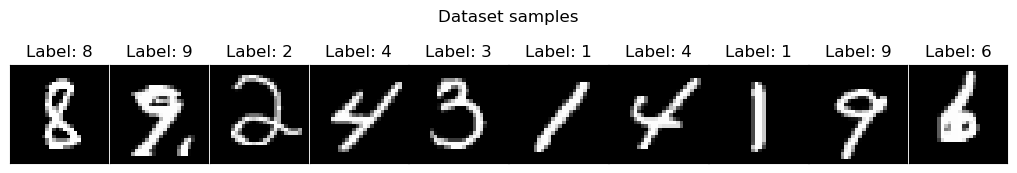

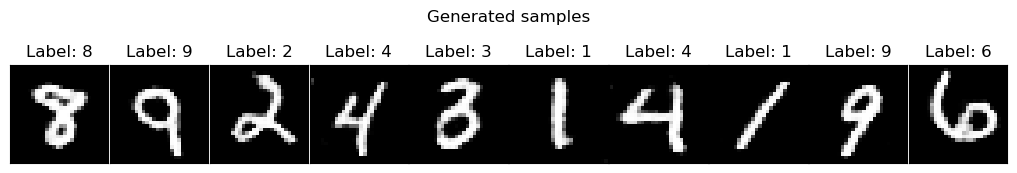

Epoch: 40, G loss: -0.6951849522186055, D loss: 1.3413817957422556


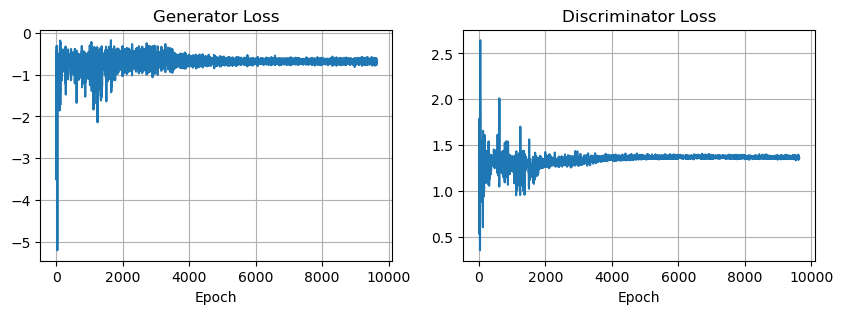

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [09:13<00:00, 11.06s/it]


In [15]:
train_losses = train_vanilla_cond(
    train_mnist_loader,
    G_cond,
    D_cond,
    G_cond_optim,
    D_cond_optim,
    discriminator_steps=DISC_STEPS,
    n_epochs=N_EPOCHS,
    visualize_steps=VIS_STEPS,
)

### 3.2 Training class-conditional GANs with Non-saturating GAN loss with $R_1$ regularization (4 points)

In [ ]:
def ns_gen_step(
    X: torch.Tensor, G: nn.Module, D: nn.Module, G_optim: torch.optim.Optimizer, num_classes: int
) -> torch.Tensor:
    # YOUR CODE HERE
    ...

In [ ]:
def ns_discr_step(
    X: torch.Tensor,
    real_labels: torch.Tensor,
    G: nn.Module,
    D: nn.Module,
    D_optim: torch.optim.Optimizer,
    r1_regularizer: float = 1.0,
) -> torch.Tensor:
    # YOUR CODE HERE
    ...

In [ ]:
def train_ns(
    train_loader: DataLoader,
    G: nn.Module,
    D: nn.Module,
    G_optim: torch.optim.Optimizer,
    D_optim: torch.optim.Optimizer,
    discriminator_steps: int,
    n_epochs: int,
    r1_regularizer: float = 1.0,
    visualize_steps: int = 10,
) -> None:
    # YOUR CODE HERE
    ...

In [ ]:
BATCH_SIZE = ... # YOUR CODE HERE
DISC_STEPS = ... # YOUR CODE HERE
VIS_STEPS = ... # YOUR CODE HERE
LR = ... # YOUR CODE HERE
R1_REGULARIZER = ... # YOUR CODE HERE
N_EPOCHS = ... # YOUR CODE HERE

In [ ]:
train_mnist_loader = ... # YOUR CODE HERE
G_NS = ... # YOUR CODE HERE
D_NS = ... # YOUR CODE HERE
G_NS_optim = ... # YOUR CODE HERE
D_NS_optim = ... # YOUR CODE HERE

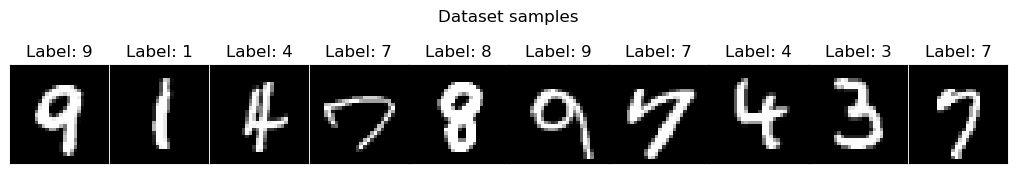

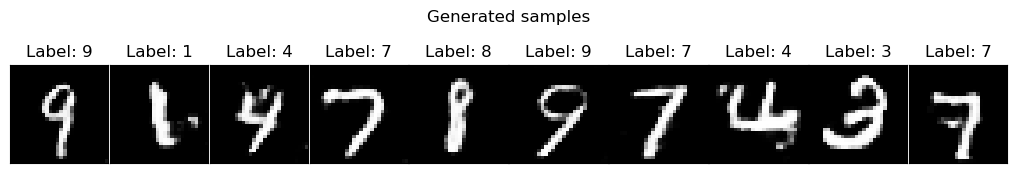

Epoch: 40, G loss: 1.1755309354891885, D loss: 1.1511223806531303


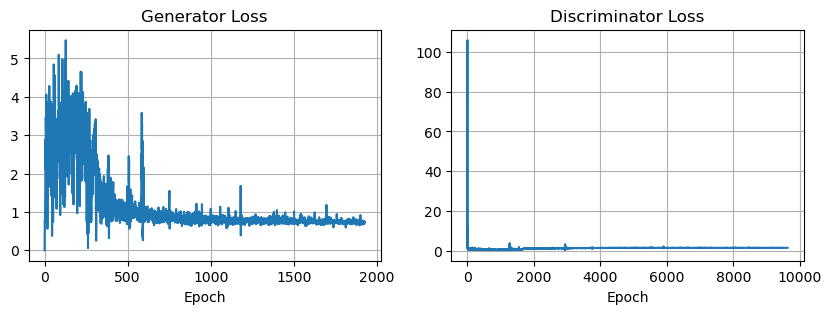

100%|█████████████████████████████████████████████████████████████████████████████████████| 50/50 [08:36<00:00, 10.34s/it]


In [21]:
train_losses = train_ns(
    train_mnist_loader,
    G_NS,
    D_NS,
    G_NS_optim,
    D_NS_optim,
    discriminator_steps=DISC_STEPS,
    n_epochs=N_EPOCHS,
    r1_regularizer=R1_REGULARIZER,
    visualize_steps=VIS_STEPS,
)

## 4. GAN with class-conditional generator and unconditional discriminator (3 points)

For this task, you need to:  
1. Implement the architecture for an **unconditional discriminator** (1 point);  
2. Implement the **training steps and algorithm** (2 points). 

In [ ]:
class ConvDiscriminator(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        self.n_channels = 64

        self.net = nn.Sequential(
            nn.Conv2d(...)m # YOUR CODE HERE
            nn.LeakyReLU(...), # YOUR CODE HERE
            ... # YOUR CODE HERE
        )
        self.linear = ... # YOUR CODE HERE

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return ... # YOUR CODE HERE

In [ ]:
def ns_gen_step_uncond(
    X: torch.Tensor, G: nn.Module, D: nn.Module, G_optim: torch.optim.Optimizer, num_classes: int
) -> torch.Tensor:
    # YOUR CODE HERE
    ...


def ns_discr_step_uncond(
    X: torch.Tensor,
    G: nn.Module,
    D: nn.Module,
    D_optim: torch.optim.Optimizer,
    r1_regularizer: float = 1.0,
) -> torch.Tensor:
    # YOUR CODE HERE
    ...

In [ ]:
def train_ns_uncond(
    train_loader: DataLoader,
    G: nn.Module,
    D: nn.Module,
    G_optim: torch.optim.Optimizer,
    D_optim: torch.optim.Optimizer,
    discriminator_steps: int,
    n_epochs: int,
    r1_regularizer: float = 1.0,
    visualize_steps: int = 10,
) -> None:
    # YOUR CODE HERE
    ...

In [ ]:
BATCH_SIZE = ... # YOUR CODE HERE
DISC_STEPS = ... # YOUR CODE HERE
VIS_STEPS = ... # YOUR CODE HERE
LR = ... # YOUR CODE HERE
R1_REGULARIZER = ... # YOUR CODE HERE
N_EPOCHS = ... # YOUR CODE HERE

In [ ]:
train_mnist_loader = ... # YOUR CODE HERE
G_UNCOND = ... # YOUR CODE HERE
D_UNCOND = ... # YOUR CODE HERE
G_UNCOND_optim = ... # YOUR CODE HERE
D_UNCOND_optim = ... # YOUR CODE HERE

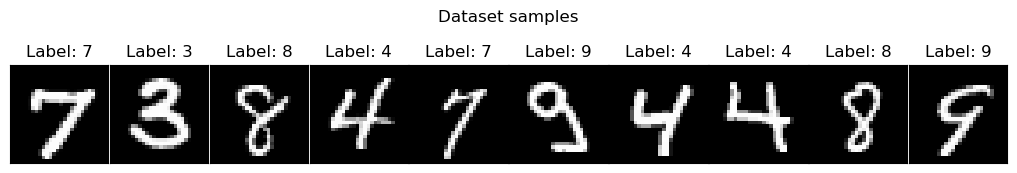

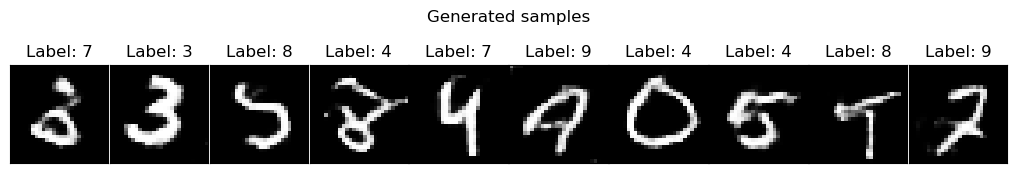

Epoch: 40, G loss: 2.107890284345062, D loss: 1.0808430320824511


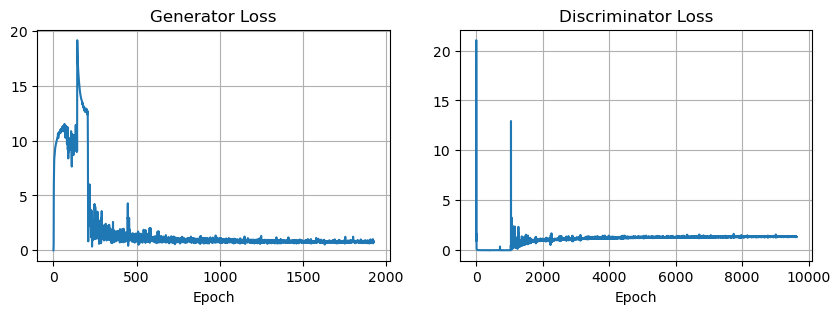

100%|█████████████████████████████████████████████████████████████████████████████████████| 50/50 [08:13<00:00,  9.86s/it]


In [27]:
train_losses = train_ns_uncond(
    train_mnist_loader,
    G_UNCOND,
    D_UNCOND,
    G_UNCOND_optim,
    D_UNCOND_optim,
    discriminator_steps=DISC_STEPS,
    n_epochs=N_EPOCHS,
    r1_regularizer=R1_REGULARIZER,
    visualize_steps=VIS_STEPS,
)

## 5. Evaluation of Model Results (6 points)  
In this task, you need to evaluate the performance of each trained model **on the MNIST test subset**.  

### 5.1 Qualitative Evaluation (1 point)  

Visualize **class-conditional generation** from models with a **conditional discriminator**, specifying the class label, trained using:  
- **Vanilla GAN loss** 
- **NS-GAN loss (with $R_1$ regularization)** 
- **Class-conditional generation** from model with an **unconditional discriminator**

In [ ]:
transform = ... # YOUR CODE HERE

test_dataset = ... # YOUR CODE HERE

In [ ]:
dataloader = ... # YOUR CODE HERE

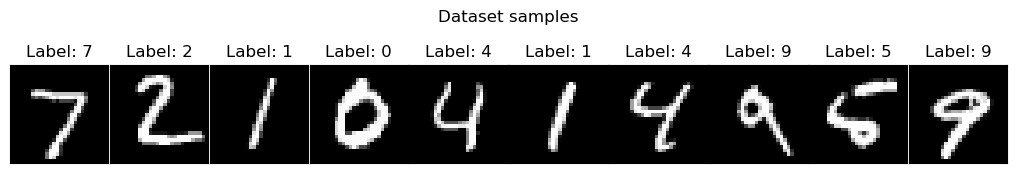

In [34]:
X, labels = next(iter(dataloader))
plot_images(X[:10].cpu(), labels[:10].cpu(), "Dataset samples")

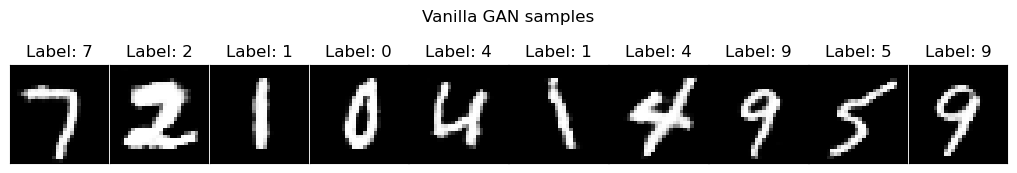

In [35]:
X_gen_cond = G_cond.sample(10, labels[:10].to(DEVICE))
plot_images(X_gen_cond.detach().cpu(), labels[:10].cpu(), "Vanilla GAN samples")

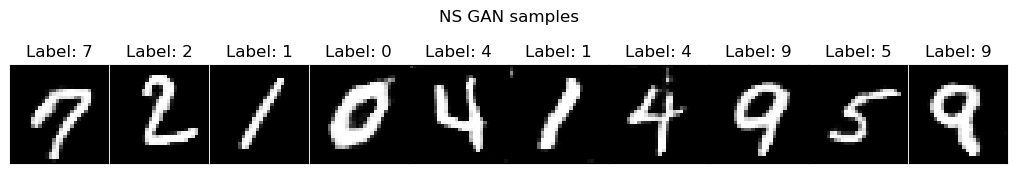

In [36]:
X_gen_ns = G_NS.sample(10, labels[:10].to(DEVICE))
plot_images(X_gen_ns.detach().cpu(), labels[:10].cpu(), "NS GAN samples")

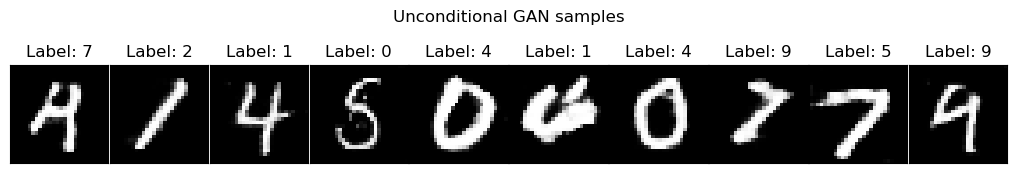

In [37]:
X_gen_uncond = G_UNCOND.sample(10, labels[:10].to(DEVICE))
plot_images(X_gen_uncond.detach().cpu(), labels[:10].cpu(), "Unconditional GAN samples")

### 5.2 Quantitative Evaluation (FID) (3 points) 

You should:
- Compute the **Frechet Inception Distance (FID)** for all trained models:  
    - Conditional discriminator (Vanilla GAN loss)  
    - Conditional discriminator (NS-GAN loss)  
    - Unconditional discriminator
- Compare FID scores across models to assess which architecture and loss function yield the most realistic generations.

Compute FID metrics for `MNIST` images with `torchmetrics` by following these steps:

1. **Preprocess images:** Resize to 299×299 and convert from grayscale to RGB by stacking 3 times color channels.
2. **Implement FID calculation** using the prepared images

In [ ]:
def preprocess_for_fid(images: torch.Tensor, device: torch.device = DEVICE) -> torch.Tensor:
    """
    Preprocess grayscale [B, 1, H, W] images normalized to [-1, 1] for FID:
        1. Scale from [-1, 1] to [0, 1]
        2. Convert to RGB by repeating channels
        3. Resize to (299, 299)
        4. Convert to uint8 in [0, 255]

    Returns:
        torch.Tensor: Preprocessed images [B, 3, 299, 299] in uint8 format
    """
    if images.dim() == 3:
        images = images.unsqueeze(1)  # [B, H, W] -> [B, 1, H, W]

    images = ... # YOUR CODE HERE

    # Batch operations for efficiency
    images = ... # YOUR CODE HERE  # [B, 1, 299, 299]
    images = ... # YOUR CODE HERE  # [B, 3, 299, 299] (grayscale->RGB)

    # Convert to uint8 and ensure proper range
    images = ... # YOUR CODE HERE

    return images.to(device)

In [ ]:
@torch.no_grad()
def compute_fid(
    generator: ConditionalConvGenerator,
    loader: DataLoader,
    num_features: int = 2048,
    device: torch.device = DEVICE,
) -> dict[str, float]:
    """Compute Fréchet Inception Distance (FID) between real and generated samples."""
    fid = FrechetInceptionDistance(feature=num_features).to(device).eval()

    for real_imgs, labels in loader:
        batch_size = real_imgs.size(0)

        real_imgs = ... # YOUR CODE HERE
        labels = labels.to(device)

        fake_imgs = ... # YOUR CODE HERE
        fake_imgs = ... # YOUR CODE HERE

        ... # YOUR CODE HERE

    output = fid.compute().detach().item()

    fid.reset()

    return output

In [40]:
fid_cond = compute_fid(G_cond, dataloader)
fid_cond

7.221518039703369

In [41]:
fid_NS = compute_fid(G_NS, dataloader)
fid_NS

8.227103233337402

In [ ]:
fid_UNCOND = compute_fid(G_UNCOND, dataloader)
fid_UNCOND

10.90830135345459

### 5.3 Summary & Conclusions (2 points)
- Do the results differ between **Vanilla GAN loss** and **NS-GAN ($R_1$) loss**?  
- Do the results differ when using a **class-conditional discriminator** vs. an **unconditional discriminator**?  
- Based on both **visual inspection** and **FID scores**, justify which approach performs best.  

**Reporting**: Include FID values in a table for clear comparison. 
Example:  

| Model Type               | Loss Function       | FID Score ($\downarrow$ better) |  
|--------------------------|---------------------|----------------------|  
| Conditional Discriminator | Vanilla GAN         | 7.2                 |  
| Conditional Discriminator | NS-GAN ($R_1$)         | 8.2                 |  
| Unconditional Discriminator | NS-GAN ($R_1$)      | 10.9                |  

**Observations:** YOU OBSERVATIONS HERE.